### Package import and Data Loading

100%|██████████| 170M/170M [00:01<00:00, 97.7MB/s]


torch.Size([64, 3, 32, 32]) torch.Size([64])


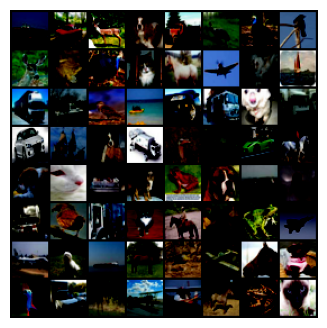

CIFAR-10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import GaussianBlur
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim


batch_size = 64  # or your preferred size

# Define transform — converts to tensor and normalizes RGB values
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor [0,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize RGB channels
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualize a batch
x, y = next(iter(train_loader))
print(x.shape, y.shape)   # Expected: torch.Size([64, 3, 32, 32])

# Convert grid of images to numpy for plotting
npimg = torchvision.utils.make_grid(x).numpy()
plt.figure(figsize=(8, 4))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.axis('off')
plt.show()

# Optional: print class names
print("CIFAR-10 classes:", train_dataset.classes)


### Function Definitions:

In [2]:
def plot_training_curves(loss_curve, accuracy_curve, epoch_markers, epochs, baseline):
    """
    Plots loss and accuracy curves for training monitoring.

    Args:
        loss_curve (list): List of recorded loss values.
        accuracy_curve (list): List of recorded accuracy values.
        epoch_markers (list): Indices where epochs ended.
        epochs (int): Number of epochs.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle("Training Curves")

    # Loss curve
    ax1.set_title("Cross-Entropy Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_xticks(epoch_markers, tuple(range(1, epochs + 1)))
    ax1.plot(loss_curve, label="Loss", color="C0")
    ax1.scatter(epoch_markers, [loss_curve[i] for i in epoch_markers], color="C0")

    # Accuracy curve
    ax2.set_title("Accuracy on Test Dataset (%)")
    ax2.set_xlabel("Epoch")
    ax2.plot(range(1, epochs + 1), accuracy_curve, label="Accuracy", color="C1", marker="o")
    # ax2.hlines(baseline, 1, epochs, linestyle="dashed", color="gray", alpha=0.5)

    fig.tight_layout()
    plt.show()

In [3]:
def plot_compare_training_curves(loss_bn, loss_no_bn, acc_bn, acc_no_bn, epochs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle("BatchNorm vs No BatchNorm – Training Curves")

    # ---- Loss ----
    ax1.plot(range(1, epochs + 1), loss_no_bn, label="No BN", color="C0", marker="o")
    ax1.plot(range(1, epochs + 1), loss_bn, label="With BN", color="C1", marker="o")
    ax1.set_title("Cross-Entropy Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    # ---- Accuracy ----
    ax2.plot(range(1, epochs + 1), acc_no_bn, label="No BN", color="C0", marker="o")
    ax2.plot(range(1, epochs + 1), acc_bn, label="With BN", color="C1", marker="o")
    ax2.set_title("Test Accuracy (%)")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy (%)")
    ax2.legend()

    fig.tight_layout()
    plt.show()


In [4]:
def train_model(model, optimizer, criterion, train_loader, test_loader, epochs):
    train_losses, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for x, y in train_loader:
            outputs = model(x)
            loss = criterion(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Average loss
        train_losses.append(running_loss / len(train_loader))

        # Evaluate accuracy
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                outputs = model(x)
                _, predicted = torch.max(outputs.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
        test_accuracies.append(100 * correct / total)

    return train_losses, test_accuracies


In [5]:
def total_variation_loss(img):
    """
    Computes total variation loss for smoothness regularization.
    """
    tv_loss = torch.sum(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) + \
              torch.sum(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))
    return tv_loss

In [6]:
def generate_class_image(net, device, class_idx, iterations=1000, lr=0.001, tv_weight=0.000185, blur_every=50):
    """
    Generates an image that maximally activates the specified class in the network.

    Args:
        net (torch.nn.Module): The trained neural network.
        device (torch.device): Device to run the generation on.
        class_idx (int): Index of the class to visualize.
        iterations (int): Number of optimization steps.
        lr (float): Learning rate.
        tv_weight (float): Weight for total variation loss.
        blur_every (int): Frequency of applying Gaussian blur for regularization.

    Returns:
        torch.Tensor: Generated class image (normalized, shape: H x W x C).
    """
    img = torch.randn((1, 3, 32, 32), requires_grad=True, device=device)
    optimizer = torch.optim.AdamW([img], lr=lr)
    blur = GaussianBlur(kernel_size=3, sigma=1)

    for i in range(iterations):
        optimizer.zero_grad()

        # Apply blur every `blur_every` iterations
        if i % blur_every == 0:
            with torch.no_grad():
                img.data = blur(img.data)

        out = net(img)
        class_loss = -out[0, class_idx] + out[0, :].mean()
        tv_loss = total_variation_loss(img) * tv_weight
        loss = class_loss + tv_loss

        loss.backward()
        optimizer.step()

        img.data = img.data.clamp(-3, 3)

    # Normalize image for visualization
    img = img.detach().cpu()
    img = img - img.min()
    img = img / img.max()
    img = img.squeeze(0).permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
    return img

In [7]:
def generate_images_for_all_classes(net, device, class_names, iterations=1050, lr=0.0015, show=True):
    """
    Generates and optionally displays class-activating images for each class in the model.

    Args:
        net (torch.nn.Module): Trained model.
        device (torch.device): CPU or GPU.
        class_names (list): List of class names corresponding to indices.
        iterations (int): Number of optimization iterations per class.
        lr (float): Learning rate.
        show (bool): Whether to display images with matplotlib.

    Returns:
        list: List of generated class images as torch.Tensor.
    """
    net.to(device)
    images = []

    for idx, class_name in enumerate(class_names):
        print(f'Generating image for class: {class_name}')
        img = generate_class_image(net, device, idx, iterations=iterations, lr=lr)
        images.append(img)

        if show:
            plt.figure(figsize=(2, 2))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'{class_name}')
            plt.show()

    return images

### Model Definition, Running and Results:

In [8]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 10

# ---- Model without BatchNorm ----
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(

            nn.Conv2d(3, 16, kernel_size= 5, padding= 2, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2), # -> (64, 4, 4)
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(64*4*4, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

# ---- Model with BatchNorm ----
class NN_BN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(

            nn.Conv2d(3, 16, kernel_size= 5, padding= 2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2), # -> (64, 4, 4)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(64*4*4, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)


criterion = nn.CrossEntropyLoss()

model_no_bn = NN()
optimizer_1 = torch.optim.SGD(model_no_bn.parameters(), lr=learning_rate)

model_bn = NN_BN()
optimizer_2 = torch.optim.SGD(model_bn.parameters(), lr=learning_rate)


In [11]:
!git clone https://github.com/fedighanmi/The-Effect-of-BatchNorm-on-NN.git

Cloning into 'The-Effect-of-BatchNorm-on-NN'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5 (delta 0), reused 5 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (5/5), done.


In [16]:
%cd The-Effect-of-BatchNorm-on-NN


/content/The-Effect-of-BatchNorm-on-NN


In [18]:
!pip freeze > requirements.txt

In [32]:
!mv "/content/drive/MyDrive/TU Dortmund/01_Poster_CIFAR10.ipynb" \
    "/content/The-Effect-of-BatchNorm-on-NN/01_Poster_CIFAR10.ipynb"


mv: cannot stat '/content/drive/MyDrive/TU Dortmund/01_Poster_CIFAR10.ipynb': No such file or directory


In [23]:
!git config --global user.email "fedi.ghanmy@gmail.com"

In [28]:
!find /content -name "01_Poster_CIFAR10.ipynb"

In [29]:
!find /content -name "*.ipynb"

In [27]:
!mv 01_Poster_CIFAR10.ipynb .

mv: cannot stat '01_Poster_CIFAR10.ipynb': No such file or directory


In [25]:
#
# !git commit -m "Add requirements.txt"
!git push


fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
# Train model without BatchNorm
loss_no_bn, acc_no_bn = train_model(model_no_bn, optimizer_1, criterion, train_loader, test_loader, epochs)

# Train model with BatchNorm
loss_bn, acc_bn = train_model(model_bn, optimizer_2, criterion, train_loader, test_loader, epochs)


In [ ]:
plot_compare_training_curves(
    loss_bn=loss_bn,
    loss_no_bn=loss_no_bn,
    acc_bn=acc_bn,
    acc_no_bn=acc_no_bn,
    epochs=epochs
)


In [ ]:
# Batch Normalized Results.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images = generate_images_for_all_classes(model_bn.to(device), device , train_dataset.classes)

In [ ]:
# Non-Batch Normalized Results.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images = generate_images_for_all_classes(model_bn.to(device), device , train_dataset.classes)

In [ ]:
# Individual Training loop

pbar1 = tqdm(range(epochs), desc="Epochs", position=0)
for epoch in pbar1:
    model_no_bn.train()
    running_loss = 0.0

    pbar2 = tqdm(train_loader, desc="Batches", position=1)
    for x, y in pbar2:
        outputs = model_no_bn(x)
        loss = criterion(outputs, y)
        optimizer_1.zero_grad()
        loss.backward()
        optimizer_1.step()

        running_loss += loss.item()

        pbar2.set_description(f"Loss: {loss.item():.4f}")

    pbar1.set_description(f"Loss: {running_loss/len(train_loader):.4f}")


# Individual Test accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x, y in test_loader:
        outputs = model(x)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')